In [1]:
!pip install tensorflow keras


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [3]:
data_dir = 'D:/9444Project/Classification/ip102_v1.1/ip102_v1.1'
images_dir = os.path.join(data_dir, 'images')


In [ ]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.txt'), sep=' ', header=None, names=['filename', 'class'])
val_df = pd.read_csv(os.path.join(data_dir, 'val.txt'), sep=' ', header=None, names=['filename', 'class'])
test_df = pd.read_csv(os.path.join(data_dir, 'test.txt'), sep=' ', header=None, names=['filename', 'class'])


In [ ]:
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
print(train_df['filename'].head())


0    00002.jpg
1    00003.jpg
2    00005.jpg
3    00006.jpg
4    00008.jpg
Name: filename, dtype: object


In [ ]:
import os

for filepath in train_df['filename'].head():
    print(f"{filepath} exists: {os.path.exists(images_dir)}")


00002.jpg exists: True
00003.jpg exists: True
00005.jpg exists: True
00006.jpg exists: True
00008.jpg exists: True


In [9]:
image_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=images_dir, 
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=images_dir, 
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=images_dir, 
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 45095 validated image filenames belonging to 102 classes.
Found 7508 validated image filenames belonging to 102 classes.
Found 22619 validated image filenames belonging to 102 classes.


In [10]:
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 102


In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
else:
    print("No GPU detected.")



train_steps = len(train_generator)
val_steps = len(validation_generator)
print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")


epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=epochs
)

for layer in base_model.layers[-23:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=epochs
)



No GPU detected.
Training steps per epoch: 1410
Validation steps per epoch: 235
Epoch 1/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 529s 375ms/step - accuracy: 0.4866 - loss: 1.9815 - val_accuracy: 0.5072 - val_loss: 1.8830
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 526s 373ms/step - accuracy: 0.5240 - loss: 1.8053 - val_accuracy: 0.5358 - val_loss: 1.7889
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 526s 373ms/step - accuracy: 0.5525 - loss: 1.6697 - val_accuracy: 0.5369 - val_loss: 1.8215
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 521s 369ms/step - accuracy: 0.5673 - loss: 1.5831 - val_accuracy: 0.5471 - val_loss: 1.7632
Epoch 8/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.0000e+00 - loss: 0.0000e

In [23]:
#model.save('trained_mobilenet.h5')
model.save('trained_mobilenet.keras')

In [15]:
# 评估模型
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

707/707 ━━━━━━━━━━━━━━━━━━━━ 273s 386ms/step - accuracy: 0.5490 - loss: 1.8187
Test accuracy: 0.6003801822662354


In [16]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

print(f"Total training steps per epoch: {len(train_generator)}")
print(f"Total validation steps per epoch: {len(validation_generator)}")

x_batch, y_batch = next(train_generator)
print(f"Batch X shape: {x_batch.shape}")
print(f"Batch Y shape: {y_batch.shape}")


Training samples: 45095
Validation samples: 7508
Total training steps per epoch: 1410
Total validation steps per epoch: 235
Batch X shape: (32, 224, 224, 3)
Batch Y shape: (32, 102)


707/707 ━━━━━━━━━━━━━━━━━━━━ 143s 203ms/step


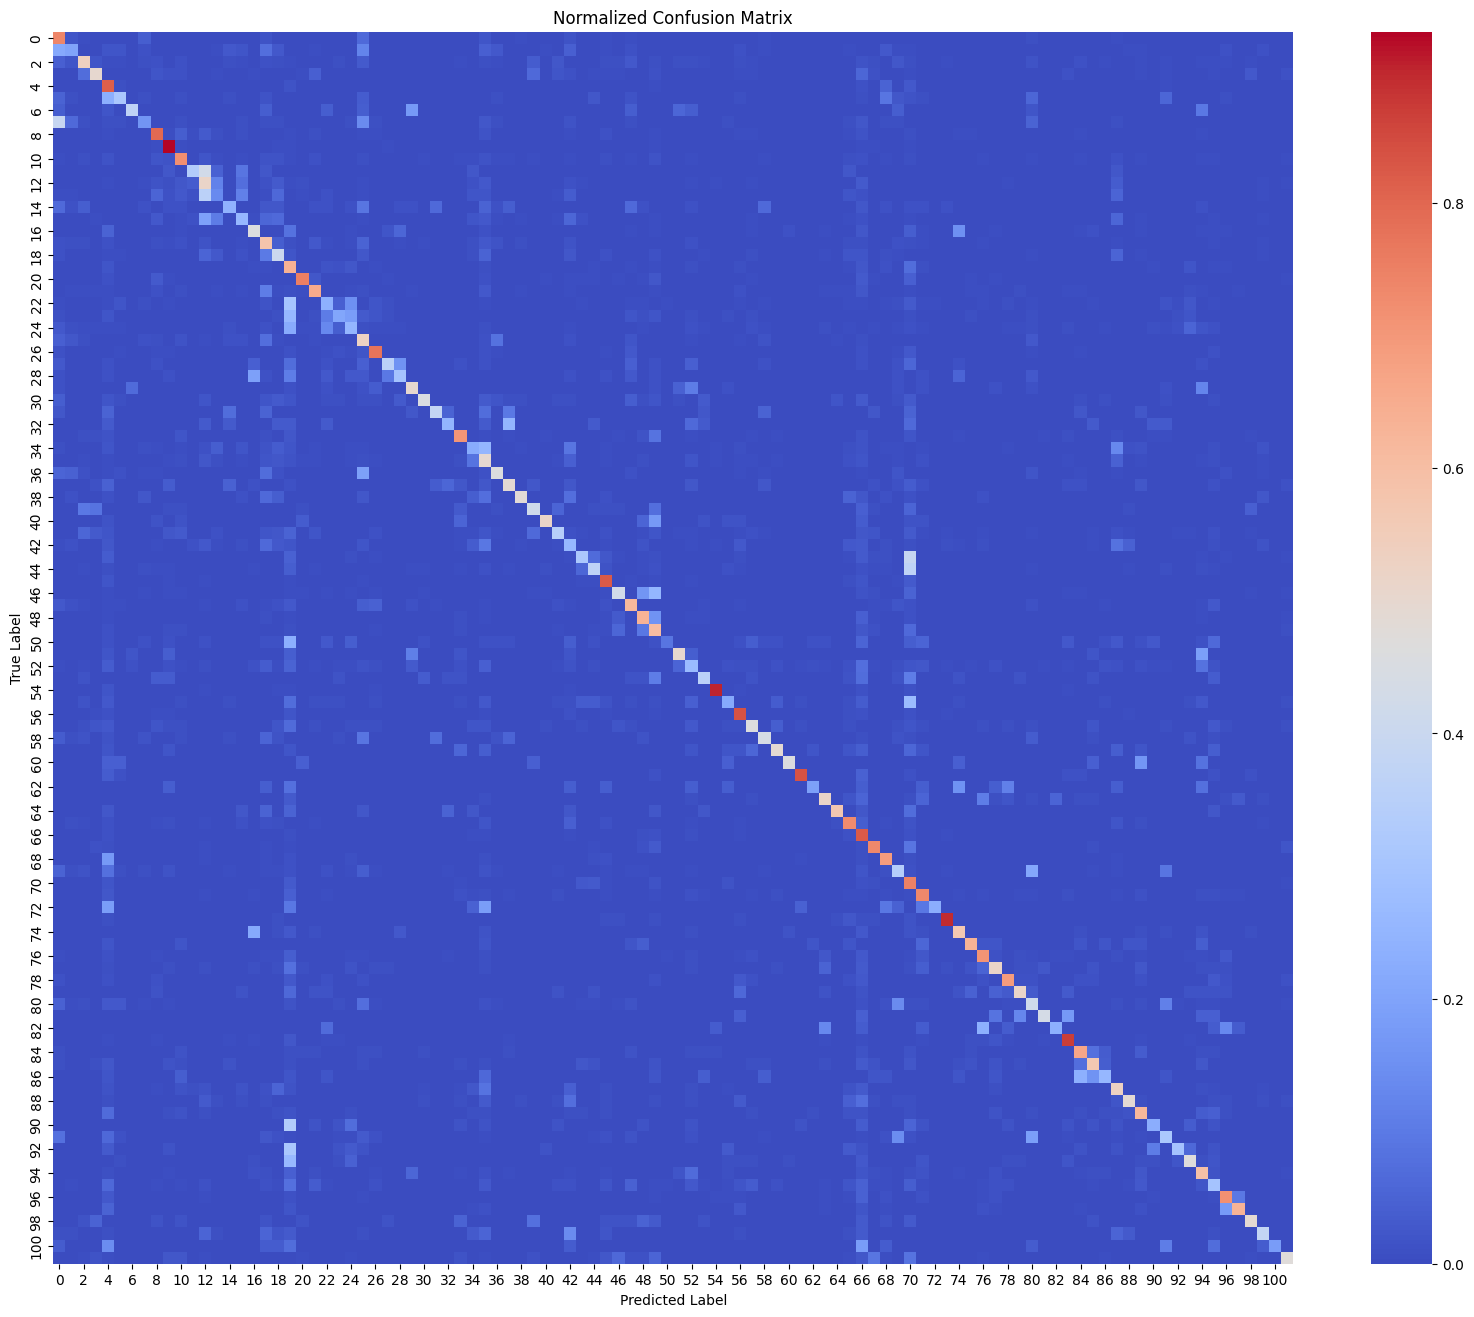

              precision    recall  f1-score   support

           0       0.53      0.74      0.62       335
           1       0.32      0.20      0.24       147
           2       0.64      0.54      0.58       257
           3       0.61      0.50      0.55       138
           4       0.77      0.81      0.79      1723
           5       0.42      0.31      0.36       122
           6       0.63      0.37      0.46        52
           7       0.29      0.16      0.21       123
           8       0.72      0.80      0.75       258
           9       0.84      0.93      0.88       495
          10       0.65      0.72      0.68       267
          11       0.41      0.33      0.37        45
          12       0.39      0.52      0.44       257
          13       0.19      0.14      0.16       148
          14       0.37      0.24      0.29        79
          15       0.29      0.26      0.27       144
          16       0.50      0.46      0.48       159
          17       0.54    

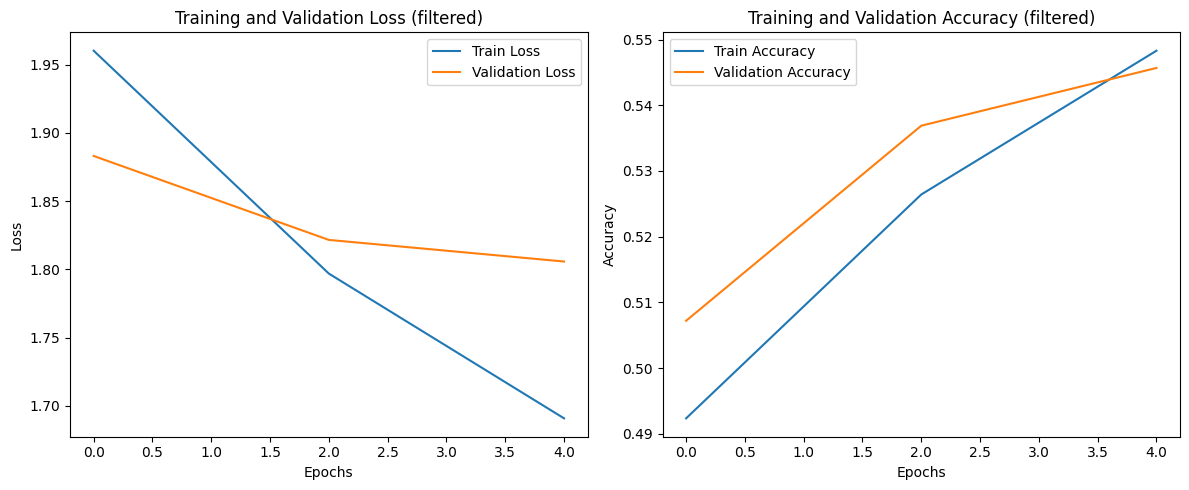

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)

norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(20, 16))
sns.heatmap(norm_conf_matrix, annot=False, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()





print(classification_report(y_true, y_pred))


history.history.update({f'fine_{k}': v for k, v in history_fine_tune.history.items()})


train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
train_accuracy = np.array(history.history['accuracy'])
val_accuracy = np.array(history.history['val_accuracy'])


min_length = min(len(train_loss), len(val_loss), len(train_accuracy), len(val_accuracy))
train_loss = train_loss[:min_length]
val_loss = val_loss[:min_length]
train_accuracy = train_accuracy[:min_length]
val_accuracy = val_accuracy[:min_length]


valid_indices = (train_loss != 0) & (val_loss != 0)


filtered_train_loss = train_loss[valid_indices]
filtered_val_loss = val_loss[valid_indices]
filtered_train_accuracy = train_accuracy[valid_indices]
filtered_val_accuracy = val_accuracy[valid_indices]
filtered_epochs = np.arange(len(train_loss))[valid_indices]  


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(filtered_epochs, filtered_train_loss, label='Train Loss')
plt.plot(filtered_epochs, filtered_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (filtered)')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(filtered_epochs, filtered_train_accuracy, label='Train Accuracy')
plt.plot(filtered_epochs, filtered_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (filtered)')
plt.legend()

plt.tight_layout()
plt.show()


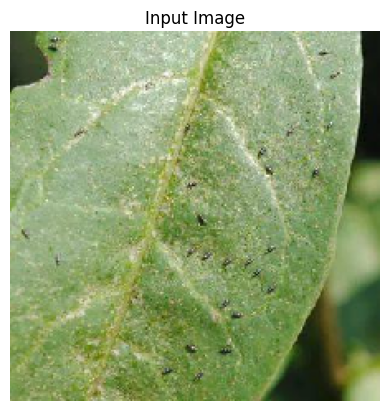

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Class: 24


In [ ]:
from tensorflow.keras.preprocessing import image
#img_path = 'Detection\VOC2007\JPEGImages\JPEGImages\IP000000010.jpg' 
img_path = 'Classification/ip102_v1.1/ip102_v1.1/images/39224.jpg'
img = image.load_img(img_path, target_size=(224, 224))


plt.imshow(img)
plt.axis('off')
plt.title('Input Image')
plt.show()

img_array = image.img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0  

predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions, axis=1)[0]  

class_labels = {v: k for k, v in test_generator.class_indices.items()}  
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_label}")

In [ ]:
conf_matrix_no_diag = conf_matrix.copy()
np.fill_diagonal(conf_matrix_no_diag, 0)  

max_value = np.max(conf_matrix_no_diag)
max_index = np.unravel_index(np.argmax(conf_matrix_no_diag), conf_matrix_no_diag.shape)

print(f'class {max_index[0]} and class {max_index[1]} has biggest mismatch, total {max_value} times')


class 44 and class 70 has biggest mismatch, total 91 times
